### Imports

In [128]:
# !LD_LIBRARY_PATH=$HOME/miniconda3/lib:$LD_LIBRARY_PATH
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [129]:
import numpy as np
import tensorflow as tf
import keras
import os, shutil

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import regularizers
import seaborn as sns
from sklearn import metrics
from pathlib import Path

TensorFlow version: 2.14.1
Keras version: 2.14.0


### Visualizing the data

In [130]:

def visualize_confusion_matrix_for_models(X_test, Y_test, *models) -> None:
    """
    Visualizes the confusion matrices for multiple machine learning models.

    Parameters:
        X_test (array-like): Test data features.
        Y_test (array-like): True labels for the test data.
        *models (variable-length argument list): Machine learning models to evaluate.

    Returns:
        None. Displays confusion matrices using seaborn's heatmap.
    """
    num_models = len(models)
    plt.figure(figsize=(5 * num_models, 5))
    for i, model in enumerate(models, 1):
        plt.subplot(1, num_models, i)
        Y_pred = model.predict(X_test)
        Y_pred = (Y_pred > 0.5)
        matrix = metrics.confusion_matrix(Y_test, Y_pred)
        hm = sns.heatmap(matrix,
                         cmap='coolwarm',
                         linecolor='white',
                         linewidths=1,
                         annot=True,
                         fmt='d')
        plt.yticks(rotation=0)
        hm.set_ylim(0, len(matrix))
        plt.title(f'Confusion Matrix - Model {i}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_accuracy_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation accuracy comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation accuracy values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots

    for i, history in enumerate(histories):
        epochs = np.arange(1, len(history.history['acc']) + 1)
        
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')

    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



def plot_loss_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation loss comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation loss values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots
    epochs = np.arange(1, len(histories[0].history['loss']) + 1)  # Assuming all models have the same number of epochs

    for i, history in enumerate(histories):
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(epochs, loss, color + 'o', label=f'Training loss for {label}')
        plt.plot(epochs, val_loss, color, label=f'Validation loss for {label}')

    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
def print_val_accuracies(history1, history2, history3):
    val_accuracy1 = history1.history['val_acc']
    val_accuracy2 = history2.history['val_acc']
    val_accuracy3 = history3.history['val_acc']

    argmax1 = np.argmax(val_accuracy1)
    argmax2 = np.argmax(val_accuracy2)
    argmax3 = np.argmax(val_accuracy3)

    print ('Max accuracy for model 1 is: ', val_accuracy1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
    print ('Max accuracy for model 2 is: ', val_accuracy2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
    print ('Max accuracy for model 3 is: ', val_accuracy3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

### Get data

In [131]:
kaggle_dir = "kaggle"
    
processed_dir = kaggle_dir + "/processed"

cats_and_dogs_small_dir = processed_dir + "/cats_and_dogs_small"

base_dir = cats_and_dogs_small_dir + "/"

train_dir: str = base_dir + "train/"

train_cats_dir: str = train_dir + "cats/"
train_dogs_dir: str = train_dir + "dogs/"

validation_dir: str = base_dir + "validation/"

validation_cats_dir: str = validation_dir + "cats/"
validation_dogs_dir: str = validation_dir + "dogs/"

test_dir: str = base_dir + "test/"

test_cats_dir: str = test_dir + "cats/"
test_dogs_dir: str = test_dir + "dogs/"

models_dir: str = "models/"

In [132]:
from pathlib import Path

def create_dir_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def create_dirs():
    all_paths: list[str] = [kaggle_dir, processed_dir, cats_and_dogs_small_dir,
                            base_dir, train_dir, train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir, test_cats_dir, test_dogs_dir]
    
    for path in all_paths:
        create_dir_if_not_exists(path)

def copy_train_images(indices: np.ndarray, animal: str ='cat', dir_type: str ='train'):
    for index in indices:
        src: str = f"kaggle/original/train/{animal}.{index}.jpg"
        dst: str = f"kaggle/processed/cats_and_dogs_small/{dir_type}/{animal}s/{animal}.{index}.jpg"
        shutil.copyfile(src, dst)

def remove_images():
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir, ignore_errors=True)

def copy_all_images(validation_size=500, test_size=1000, max_train_size=20000):
    remove_images()

    create_dirs()
    print("Dirs created")
    
    files: list[str] = os.listdir("kaggle/original/train")

    cats_count: int = sum(1 for file in files if file.startswith("cat"))
    dogs_count: int = sum(1 for file in files if file.startswith("dog"))

    train_size_cats: int = min(cats_count - validation_size - test_size, max_train_size)
    train_size_dogs: int = min(dogs_count - validation_size - test_size, max_train_size)

    indices_cats = np.random.permutation(cats_count)
    indices_dogs = np.random.permutation(dogs_count)

    indices_cats_train = indices_cats[:train_size_cats]
    indices_dogs_train = indices_dogs[:train_size_dogs]

    indices_cats_validation = indices_cats[train_size_cats:train_size_cats + validation_size]
    indices_dogs_validation = indices_dogs[train_size_dogs:train_size_dogs + validation_size]

    indices_cats_test = indices_cats[train_size_cats + validation_size:train_size_cats + validation_size + test_size]
    indices_dogs_test = indices_dogs[train_size_dogs + validation_size:train_size_dogs + validation_size + test_size]


    copy_train_images(indices_cats_train, 'cat', 'train')
    copy_train_images(indices_dogs_train, 'dog', 'train')
    print("Train images copied")

    copy_train_images(indices_cats_validation, 'cat', 'validation')
    copy_train_images(indices_dogs_validation, 'dog', 'validation')
    print("Validation images copied")

    copy_train_images(indices_cats_test, 'cat', 'test')
    copy_train_images(indices_dogs_test, 'dog', 'test')
    print("Test images copied")

    print("All images copied")

In [133]:
copy_all_images(max_train_size=4000)

Dirs created
Train images copied
Validation images copied
Test images copied
All images copied


# Model

## Number of epochs

In [134]:
epochs_count: int = 5

## Structure

In [135]:
img_rows, img_cols = 150, 150

model1 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_79 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_80 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_77 (MaxPooli  (None, 17, 17, 128)     

In [136]:
model2 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_83 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_80 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_84 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_51 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_81 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                     

In [137]:
model3 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_85 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_89 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_55 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_56 (Dropout)        (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_86 (MaxPooli  (None, 36, 36, 64)      

In [138]:
model4 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='LeakyReLU'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_93 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_90 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_94 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_59 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_61 (Dropout)        (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_91 (MaxPooli  (None, 36, 36, 64)      

In [139]:
model5 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model5.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_95 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_99 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_63 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_66 (Dropout)        (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_96 (MaxPooli  (None, 36, 36, 64)      

## Data Augumentation

In [140]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        class_mode='binary')

KeyboardInterrupt: 

## Training

In [ ]:
# history1 = model1.fit_generator(
history1 = model1.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs_count,
      validation_data=validation_generator,
      validation_steps=50)

history2 = model2.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/5
100/100 [==============================] - 17s 136ms/step - loss: 0.6938 - acc: 0.5070 - val_loss: 0.6916 - val_acc: 0.5000
Epoch 2/5
100/100 [==============================] - 16s 163ms/step - loss: 0.6944 - acc: 0.5010 - val_loss: 0.6905 - val_acc: 0.5230
Epoch 3/5
100/100 [==============================] - 14s 134ms/step - loss: 0.6917 - acc: 0.5160 - val_loss: 0.6880 - val_acc: 0.5820
Epoch 4/5
100/100 [==============================] - 16s 162ms/step - loss: 0.6866 - acc: 0.5440 - val_loss: 0.6963 - val_acc: 0.5140
Epoch 5/5
100/100 [==============================] - 14s 135ms/step - loss: 0.6843 - acc: 0.5485 - val_loss: 0.6836 - val_acc: 0.5310
Epoch 1/5
100/100 [==============================] - 19s 166ms/step - loss: 0.8972 - acc: 0.5495 - val_loss: 0.9488 - val_acc: 0.5000
Epoch 2/5
100/100 [==============================] - 14s 135ms/step - loss: 0.7843 - acc: 0.5975 - val_loss: 1.0443 - val_acc: 0.5000
Epoch 3/5
100/100 [==============================] - 15s 151ms

In [ ]:
history3 = model3.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/5


2024-04-12 15:59:55.797198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 28s 248ms/step - loss: 0.9082 - acc: 0.5180 - val_loss: 0.7046 - val_acc: 0.5000
Epoch 2/5
100/100 [==============================] - 21s 213ms/step - loss: 0.7912 - acc: 0.5705 - val_loss: 0.7341 - val_acc: 0.5000
Epoch 3/5
100/100 [==============================] - 16s 154ms/step - loss: 0.7580 - acc: 0.5805 - val_loss: 0.7312 - val_acc: 0.4990
Epoch 4/5
100/100 [==============================] - 18s 179ms/step - loss: 0.7595 - acc: 0.5850 - val_loss: 0.9029 - val_acc: 0.5030
Epoch 5/5
100/100 [==============================] - 15s 153ms/step - loss: 0.7557 - acc: 0.5705 - val_loss: 0.7509 - val_acc: 0.5370


In [ ]:
history4 = model4.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/5


2024-04-12 16:01:36.075424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 23s 186ms/step - loss: 0.8342 - acc: 0.5605 - val_loss: 0.7236 - val_acc: 0.5000
Epoch 2/5
100/100 [==============================] - 16s 161ms/step - loss: 0.7667 - acc: 0.5710 - val_loss: 0.8510 - val_acc: 0.5000
Epoch 3/5
100/100 [==============================] - 19s 186ms/step - loss: 0.7233 - acc: 0.5975 - val_loss: 0.8490 - val_acc: 0.5000
Epoch 4/5
100/100 [==============================] - 16s 156ms/step - loss: 0.7139 - acc: 0.5790 - val_loss: 1.0363 - val_acc: 0.5000
Epoch 5/5
100/100 [==============================] - 18s 180ms/step - loss: 0.7123 - acc: 0.5825 - val_loss: 0.7874 - val_acc: 0.5170


In [ ]:
# plt.imshow(train_generator.next()[0][0])
# plt.show()

In [ ]:
history5 = model5.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/5


2024-04-12 16:03:06.293870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 20s 167ms/step - loss: 0.7903 - acc: 0.5280 - val_loss: 0.6945 - val_acc: 0.5000
Epoch 2/5
100/100 [==============================] - 20s 197ms/step - loss: 0.7134 - acc: 0.5625 - val_loss: 0.7365 - val_acc: 0.5000
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.7103 - acc: 0.5625

100/100 [==============================] - 17s 165ms/step - loss: 0.7103 - acc: 0.5625 - val_loss: 0.7237 - val_acc: 0.5050
Epoch 4/5
100/100 [==============================] - 19s 185ms/step - loss: 0.6852 - acc: 0.5955 - val_loss: 0.7086 - val_acc: 0.5240
Epoch 5/5
100/100 [==============================] - 17s 172ms/step - loss: 0.6966 - acc: 0.5825 - val_loss: 0.7620 - val_acc: 0.5130


## Save model

In [ ]:
model1.save(models_dir + 'cats_and_dogs_small_1.h5')
model2.save(models_dir + 'cats_and_dogs_small_2.h5')
model3.save(models_dir + 'cats_and_dogs_small_3.h5')
model4.save(models_dir + 'cats_and_dogs_small_4.h5')
model5.save(models_dir + 'cats_and_dogs_small_5.h5')


/home/lenovo/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Visualizing the metrics

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


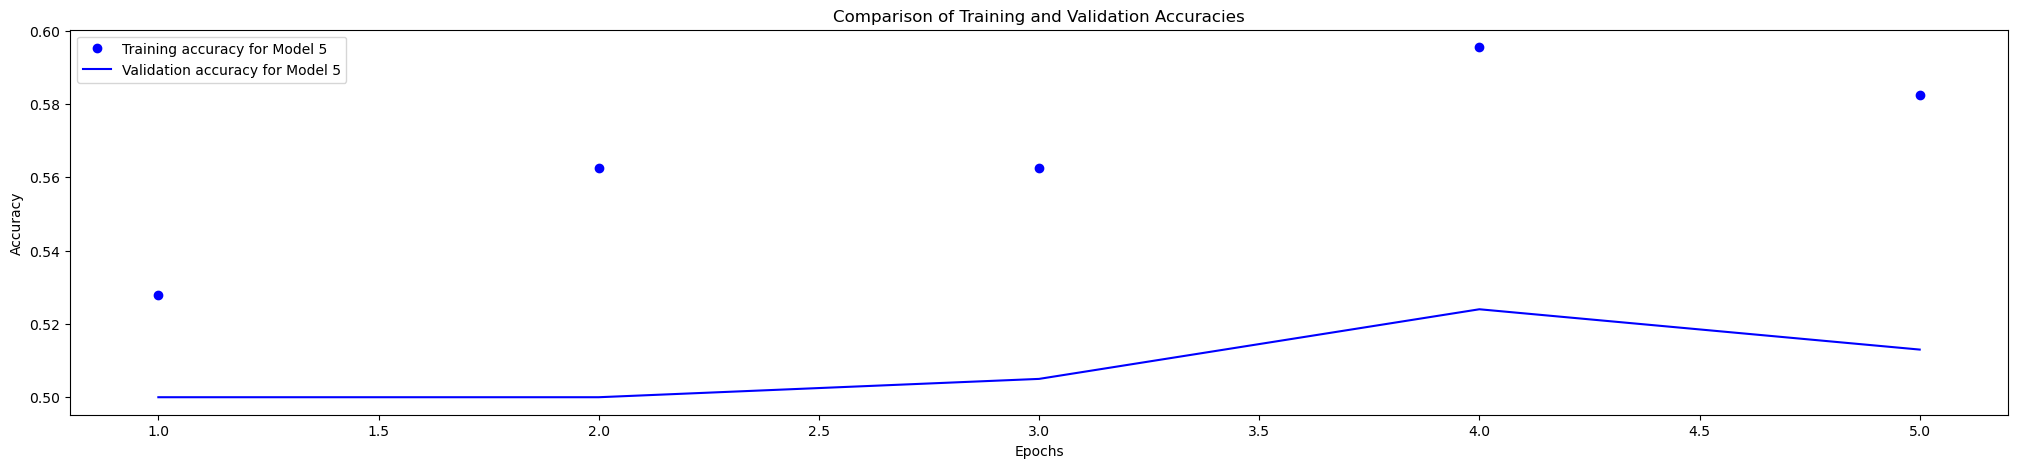

In [ ]:

# history1 shape
print(history5.history.keys())
plot_accuracy_comparison(history5, labels=['Model 5'])

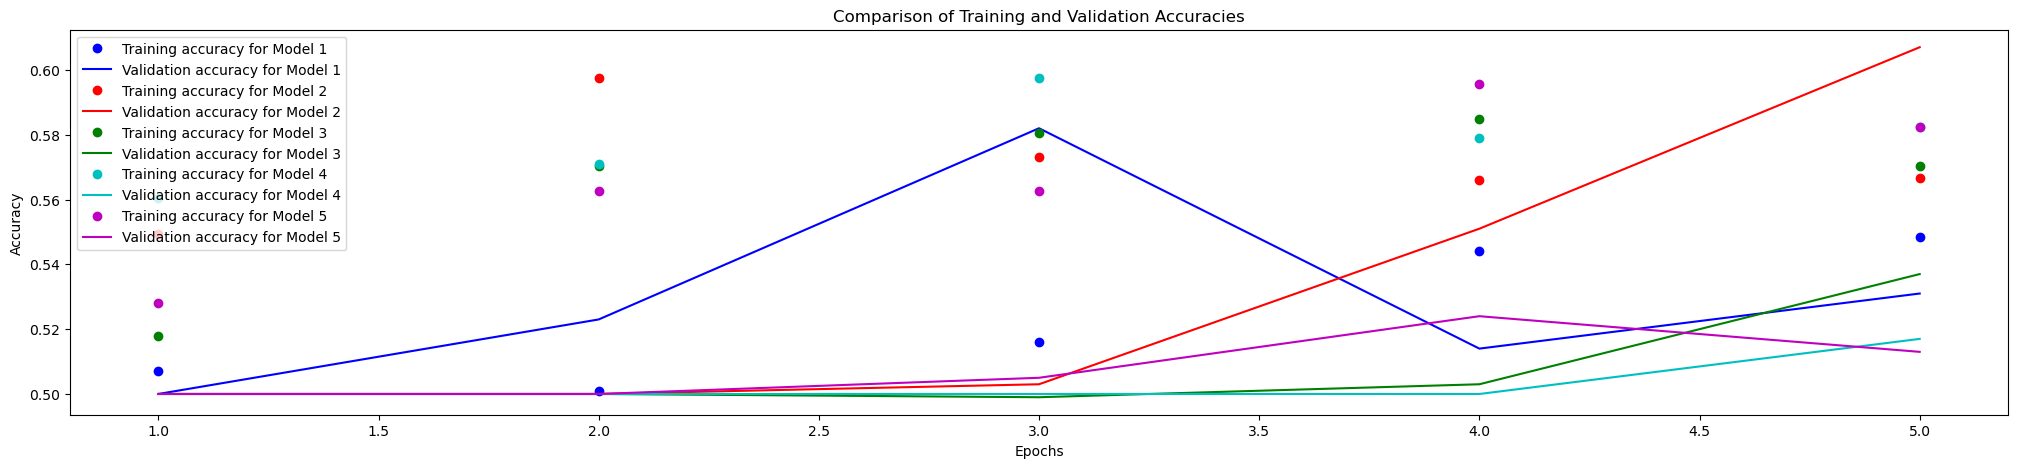

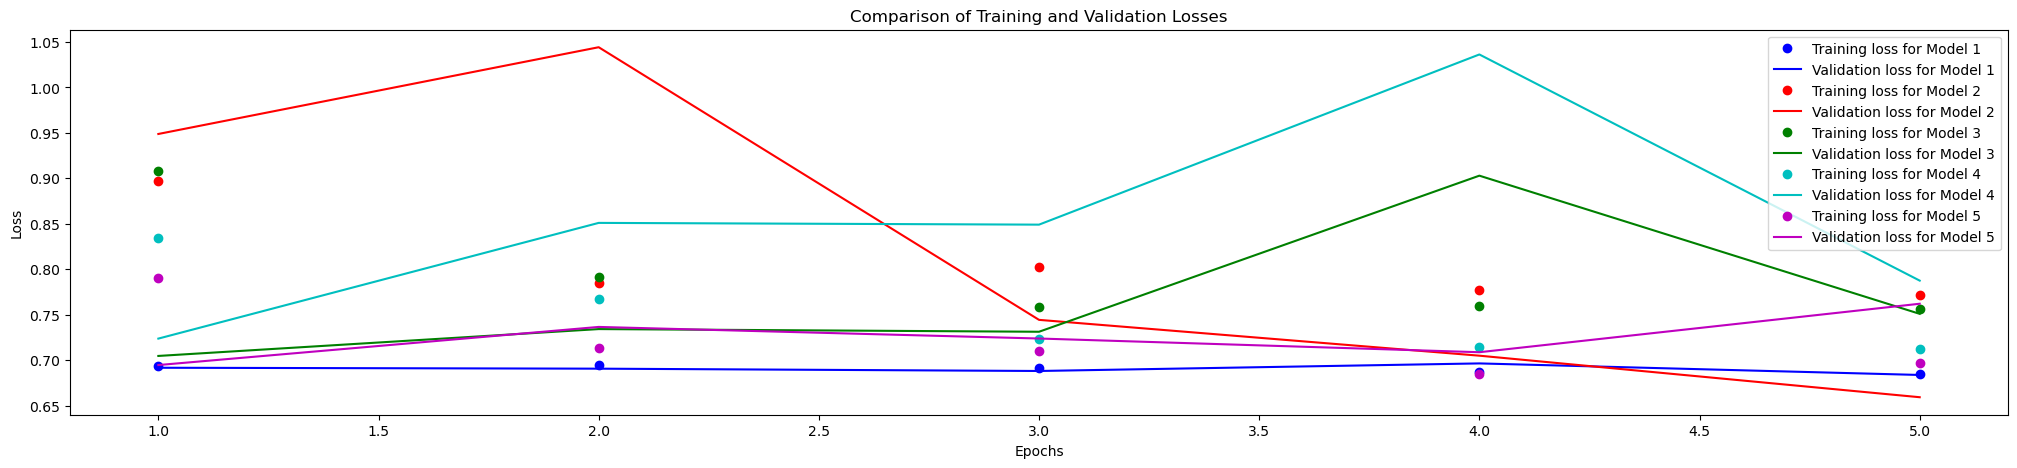

Max accuracy for model 1 is:  0.5820000171661377 , achieved in the  2 epoch.
Max accuracy for model 2 is:  0.6069999933242798 , achieved in the  4 epoch.
Max accuracy for model 3 is:  0.5370000004768372 , achieved in the  4 epoch.


In [ ]:
plot_accuracy_comparison(history1, history2, history3, history4, history5, labels=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
plot_loss_comparison(history1, history2, history3, history4, history5, labels=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
print_val_accuracies(history1, history2, history3)


# Increase number of training samples - 12000

In [ ]:
copy_all_images(max_train_size=12000)

Dirs created
Train images copied
Validation images copied
Test images copied
All images copied


## CNNs

In [ ]:
img_rows, img_cols = 150, 150

model6 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model6.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 17, 17, 128)     

In [ ]:
model7 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model7.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_34 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                     

In [ ]:
model8 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model8.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model8.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_38 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_38 (Dropout)        (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 36, 36, 64)      

In [ ]:
model9 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='LeakyReLU'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model9.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model9.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_68 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_42 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_43 (Dropout)        (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 36, 36, 64)      

In [ ]:
model10 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_29 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_30 (Dropout)        (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 36, 36, 64)       

## Learning

In [ ]:
history6 = model6.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

FileNotFoundError: [Errno 2] No such file or directory: 'kaggle/processed/cats_and_dogs_small/train/cats/cat.6208.jpg'

In [ ]:
history7 = model7.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

In [ ]:
history8 = model8.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

In [ ]:
history9 = model9.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

In [ ]:
history10 = model10.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

In [ ]:
model6.save(models_dir + 'cats_and_dogs_small_6.h5')
model7.save(models_dir + 'cats_and_dogs_small_7.h5')
model8.save(models_dir + 'cats_and_dogs_small_8.h5')
model9.save(models_dir + 'cats_and_dogs_small_9.h5')
model10.save(models_dir + 'cats_and_dogs_small_10.h5')


In [ ]:
plot_accuracy_comparison(history6, history7, history8, history9, history10, labels=['Model 6', 'Model 7', 'Model 8', 'Model 9', 'Model 10'])
plot_loss_comparison(history6, history7, history8, history9, history10, labels=['Model 6', 'Model 7', 'Model 8', 'Model 9', 'Model 10'])
print_val_accuracies(history6, history7, history8)

# Increase number of training samples - 20000

In [ ]:
copy_all_images(max_train_size=12000)

## CNNs

In [ ]:
img_rows, img_cols = 150, 150

model11 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model11.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model11.summary()

In [ ]:
model12 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model12.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model12.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_240 (Conv2D)         (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_230 (MaxPool  (None, 74, 74, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_241 (Conv2D)         (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_158 (B  (None, 72, 72, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_231 (MaxPool  (None, 36, 36, 64)        0         
 ing2D)                                                          
                                                     

In [ ]:
model13 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model13.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model13.summary()

In [ ]:
model14 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='LeakyReLU'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model14.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model14.summary()

In [ ]:
model15 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), activation='LeakyReLU'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model15.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model15.summary()

## Learning

In [ ]:
history11 = model11.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

In [ ]:
history12 = model12.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

In [ ]:
history13 = model13.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

In [ ]:
history14 = model14.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

In [ ]:
history15 = model15.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

In [ ]:
model11.save(models_dir + 'cats_and_dogs_small_11.h5')
model12.save(models_dir + 'cats_and_dogs_small_12.h5')
model13.save(models_dir + 'cats_and_dogs_small_13.h5')
model14.save(models_dir + 'cats_and_dogs_small_14.h5')
model15.save(models_dir + 'cats_and_dogs_small_15.h5')


In [ ]:
plot_accuracy_comparison(history11, history12, history13, history14, history15, labels=['Model 11', 'Model 12', 'Model 13', 'Model 14', 'Model 15'])
plot_loss_comparison(history11, history12, history13, history14, history15, labels=['Model 11', 'Model 12', 'Model 13', 'Model 14', 'Model 15'])
print_val_accuracies(history11, history12, history13)